In [30]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/Instance segmentation')
sys.path.append(str(base))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive


In [31]:
import os
os.chdir("/")
os.chdir("content/drive/My Drive/Instance segmentation")
os.listdir()

['train2017.zip',
 'annotations',
 'val2017',
 'train2017',
 'conv_autoencoder.pth',
 'Test.ipynb',
 'config.py']

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import copy, deepcopy

from PIL import Image

from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data

import tqdm
from torchsummary import summary
import seaborn as sns

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip

--2020-11-03 06:41:02--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.16.220
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.16.220|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  50.7MB/s    in 7m 46s  

2020-11-03 06:48:49 (39.6 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!unzip 'train2017.zip'
!unzip 'val2017.zip'
!unzip 'annotations_trainval2017.zip'

!rm 'train2017.zip'
!rm 'val2017.zip'
!rm 'annotations_trainval2017.zip'

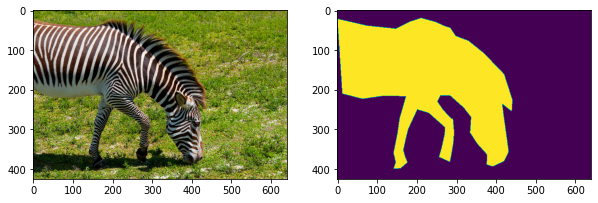

In [ ]:
#just see what's inside
img, [target] = train_data[3]

fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1,2,1)
plt.imshow(img.numpy().transpose((1, 2, 0)));

fig.add_subplot(1,2,2)
mask = train_data.coco.annToMask(target)
plt.imshow(mask);

##Prepare data

In [25]:
# https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning
class CocoDataset(data.Dataset):
  def __init__(self, root, json, transform=None):
    self.root = root
    self.coco = COCO(json)
    self.json = json
    self.ids = list(self.coco.anns.keys())
    self.transform = transform

  def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        ann_id = self.ids[index]
        #img_id = coco.anns[ann_id]['image_id']
        #path = coco.loadImgs(img_id)[0]['file_name']
        mask = coco.annToMask(coco.anns[ann_id])
        
        #image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
        #    image = self.transform(image)
            mask = self.transform(mask)

        return mask * 255
       # return image, coco.anns[ann_id]

  def __len__(self):
        return len(self.ids)


def get_loader(root, json, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       transform=transform)
    
    # Data loader for COCO dataset
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers)
    return data_loader

In [26]:
transform = transforms.Compose(
      [transforms.ToPILImage(),
       transforms.Scale(256),
       transforms.CenterCrop(224),
       transforms.ToTensor()]
       #transforms.Normalize(mean=[0.5],
                                  #std=[0.5])]
  )

val_loader = get_loader(root='val2017', 
                        json='annotations/instances_val2017.json',
                        transform=transform,
                        batch_size=16,
                        shuffle=True,
                        num_workers=0)


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [27]:
train_loader = get_loader(root='train2017', 
                        json='annotations/instances_train2017.json',
                        transform=transform,
                        batch_size=16,
                        shuffle=True,
                        num_workers=0)

loading annotations into memory...
Done (t=15.93s)
creating index...
index created!


In [ ]:
for images in train_loader:
    # image shape is [batch_size, 3 (due to RGB), height, width]
    img = transforms.ToPILImage()(images[0])
    plt.imshow(img)
    plt.show()
   # print(labels)

##Try Neptune

Результаты [тут](https://ui.neptune.ai/a.chubcheva/Instance-segmentation/experiments?viewId=standard-view)

In [ ]:
!pip install neptune-client

In [38]:
import neptune
from config import API_TOKEN

neptune.init('a.chubcheva/Instance-segmentation', api_token=API_TOKEN)

Project(a.chubcheva/Instance-segmentation)

##Autoencoder

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_autoencoder(model, criterion, optimizer, dataloader, num_epochs, epoch_len=100):

  batch_size = 16

  model.train()
  best_model_wts = deepcopy(model.state_dict())
  best_loss = 10000.
  loss_history = []
  for epoch in range(num_epochs):
    running_loss = 0
    for i in tqdm.trange(epoch_len):
        inputs = next(iter(dataloader))

        # variable image size
        k = np.random.randint(15, 20)
        inputs = F.interpolate(inputs, (k*16, k*16))

        inputs = Variable(inputs.to(device))
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(inputs.shape, outputs.shape)
        loss = criterion(outputs, inputs)
        neptune.log_metric('loss', loss)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(dataloader.dataset)
    neptune.log_metric('epoch_loss', epoch_loss)
    loss_history.append(epoch_loss)
    if epoch_loss < best_loss:
        best_model_wts = deepcopy(model.state_dict())
    print('epoch [{}/{}], loss:{:.4f}\n'.format(epoch+1, num_epochs, loss.item()))

  model.load_state_dict(best_model_wts)
  return model, loss_history

In [40]:
def test_model(model, dataloader, num_images=20):
  test_index = [14618, 4059, 5305, 9112, 12972, 26415, 3559, 25365, 24997, 22541] #просто крупные объекты
  for index in test_index:
    img = dataloader.dataset[index]
    init_img = img.squeeze().numpy()
    img = Variable(img).to(device)
    img_encoded = model(img.unsqueeze(0))
    img_encoded = img_encoded.detach().cpu().squeeze().numpy()
    neptune.log_image('encoded-masks', np.concatenate((init_img, img_encoded), axis=1)*255)

  #draw one
  fig = plt.figure(figsize=(15,6))
  fig.add_subplot(1, 2, 1)
  #index = np.random.randint(len(val_loader.dataset))
  index = 12972
  img = val_loader.dataset[index]
  plt.title('initial')
  plt.axis('off')
  #plt.imshow(img.squeeze().numpy());
  sns.heatmap(img.squeeze().numpy(), linewidth=0, xticklabels=False, yticklabels=False);

  fig.add_subplot(1, 2, 2)
  img = Variable(img).to(device)
  img_encoded = conv_autoencoder(img.unsqueeze(0))
  plt.title('after autoencoder')
  plt.axis('off')
  #plt.imshow(img_encoded.cpu().detach().numpy().squeeze());
  sns.heatmap(img_encoded.detach().cpu().squeeze().numpy(), linewidth=0, xticklabels=False, yticklabels=False);
  

1.0
1.0
(224, 448)
https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-17


1.0

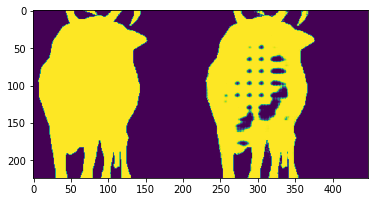

In [50]:
index = 12972
img = val_loader.dataset[index]
plt.imshow(img.squeeze().numpy())
compare_img = img.squeeze().numpy()
print(compare_img.max())
img = Variable(img).to(device)
img_encoded = conv_autoencoder(img.unsqueeze(0))
img_encoded = img_encoded.detach().cpu().squeeze().numpy()
    #
print(img_encoded.max())
img = np.concatenate((compare_img, img_encoded), axis=1)
print(img.shape)
plt.imshow(img)
neptune.create_experiment('test_img')
neptune.send_image('encoded-masks', img*255)
#img.shape
#neptune.stop()
compare_img.max()

In [51]:
neptune.stop()

In [41]:
class DiceLoss(nn.Module):
  def __init__(self) -> None:
        super(DiceLoss, self).__init__()
        self.eps = 1e-6
        self.th = 0.5
  def forward(self, inp, out):
        # shape [batch_size, 3, 224, 224]
        dims = (1, 2, 3)
        intersection = torch.sum(inp * out, dims)
        cardinality = torch.sum(inp + out, dims)
        dice_score = 2. * intersection / (cardinality + self.eps)
        return torch.mean(dice_score)


class FocalLoss(nn.Module):
  def __init__(self, alpha=1., gamma=1.) -> None:
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
  def forward(self, inp, out):
        # shape [batch_size, 3, 224, 224]

        BCE_loss = F.binary_cross_entropy(inp, out, reduce=False)
        pt = torch.exp(-BCE_loss)
        f_loss = -self.alpha * (1 - pt)**self.gamma * BCE_loss

        
        logit = inp.clamp(1e-3, 1. - 1e-3)
        loss = -1 * torch.log(logit) * out.float() # cross entropy
        loss = self.alpha * loss * (1 - logit) ** self.gamma # focal loss
        loss = torch.mean(loss)
        
        return -f_loss.mean()


        #return f_loss.mean()

class Loss(nn.Module):
  def __init__(self, alpha=1., gamma=1.) -> None:
        super(Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

  def forward(self, inp, out):
        # shape [batch_size, 3, 224, 224]
        f = FocalLoss(gamma=self.gamma)
        d = DiceLoss()
        #print(f(inp,out), d(inp, out))
        return f(inp,out) - self.alpha * d(inp, out)

###Little one

In [ ]:
class NaiveAutoencoder(nn.Module):
  def __init__(self):
        super(NaiveAutoencoder, self).__init__()
        # encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=0),
            nn.Sigmoid()
        )

    
  def forward(self, x):
        # encode
        x = self.encoder(x)

        # decode
        x = self.decoder(x)
        return x
  


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NaiveAutoencoder().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = Loss(alpha=10, gamma=3)
#criterion = nn.MSELoss()
num_epochs = 5

In [ ]:
naive_autoencoder, loss_history_ae = train_autoencoder(model,criterion, opt, val_loader, num_epochs)


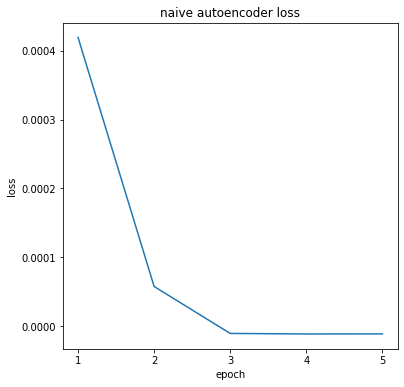

In [ ]:
plt.figure(figsize=(6,6))
plt.title('naive autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

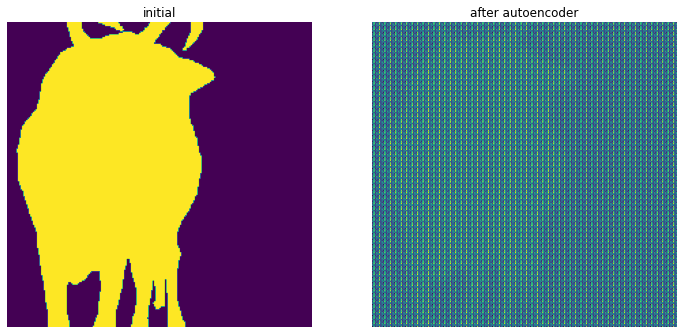

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
#index = np.random.randint(len(val_loader.dataset))
index = 12972
img = val_loader.dataset[index]
plt.title('initial')
plt.axis('off')
plt.imshow(img.squeeze().numpy());

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = naive_autoencoder(img.unsqueeze(0))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach().numpy().squeeze());

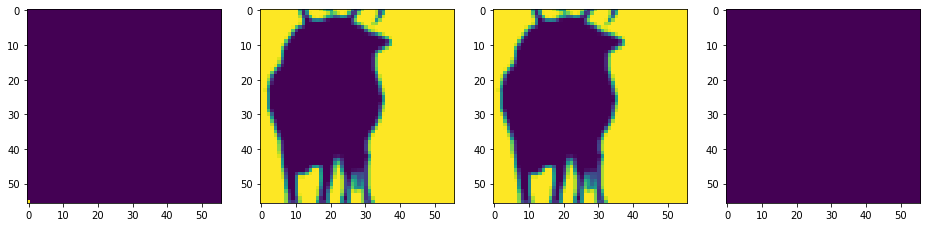

In [ ]:
hid = naive_autoencoder.encoder(img.unsqueeze(0))

fig = plt.figure(figsize=(16,4))
fig.add_subplot(1, 4, 1)
plt.imshow(hid[:,0,:,:].detach().cpu().squeeze().numpy());

fig.add_subplot(1, 4, 2)
plt.imshow(hid[:,1,:,:].detach().cpu().squeeze().numpy());

fig.add_subplot(1, 4, 3)
plt.imshow(hid[:,2,:,:].detach().cpu().squeeze().numpy());

fig.add_subplot(1, 4, 4)
plt.imshow(hid[:,3,:,:].detach().cpu().squeeze().numpy());

###Bigger one

In [42]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
#https://github.com/say4n/pytorch-segnet/blob/master/src/model.py

class Autoencoder(nn.Module):
  def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
                
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.relu = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        # decoder layers
        self.dec4 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.dec3 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.dec2 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec20 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec21 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec22 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec1 = nn.ConvTranspose2d(64, 1, 3, padding=1)

        self.sigm = nn.Sigmoid()
  
  def encode(self, x):
        
        x = self.relu(self.conv1(x))
        x1, i1 = self.pool(x)
        x1 = self.relu(self.conv2(x1))
        x2, i2 = self.pool(x1)
        x2 = self.relu(self.conv3(x2))
        x3, i3 = self.pool(x2)
        x3 = self.relu(self.conv3(x3))
        x4, i4 = self.pool(x3)

        return x4

    
  def forward(self, x):
        # encode
        dim0 = x.size()
        x = self.relu(self.conv1(x))
        x1, i1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        
        dim1 = x1.size()
        x1 = self.relu(self.conv2(x1))
        x2, i2 = F.max_pool2d(x1, kernel_size=2, stride=2, return_indices=True)
       
        dim2 = x2.size()
        x2 = self.relu(self.conv3(x2))
        x3, i3 = F.max_pool2d(x2, kernel_size=2, stride=2, return_indices=True)
        
        dim3 = x3.size()
        x3 = self.relu(self.conv4(x3))
        x4, i4 = F.max_pool2d(x3, kernel_size=2, stride=2, return_indices=True)
        

        # decode
        x4 = F.max_unpool2d(x4, i4, kernel_size=2, stride=2, output_size=dim3)
        x3 = self.relu(self.dec4(x4))

        x3 = F.max_unpool2d(x3, i3, kernel_size=2, stride=2, output_size=dim2)
        x2 = self.relu(self.dec3(x3))

        x2 = F.max_unpool2d(x2, i2, kernel_size=2, stride=2, output_size=dim1)
        x1 = self.relu(self.dec2(x2))
        x1 = self.relu(self.dec20(x1))
        x1 = self.relu(self.dec21(x1))
        x1 = self.relu(self.dec22(x1))

        x1 = F.max_unpool2d(x1, i1, kernel_size=2, stride=2, output_size=dim0)
        x = self.sigm(self.dec1(x1))
        return x

In [50]:
model = Autoencoder().to(device)
summary(model, (1, 256, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 224]             640
         LeakyReLU-2         [-1, 64, 256, 224]               0
            Conv2d-3         [-1, 64, 128, 112]          36,928
         LeakyReLU-4         [-1, 64, 128, 112]               0
            Conv2d-5          [-1, 128, 64, 56]          73,856
         LeakyReLU-6          [-1, 128, 64, 56]               0
            Conv2d-7          [-1, 256, 32, 28]         295,168
         LeakyReLU-8          [-1, 256, 32, 28]               0
   ConvTranspose2d-9          [-1, 128, 32, 28]         295,040
        LeakyReLU-10          [-1, 128, 32, 28]               0
  ConvTranspose2d-11           [-1, 64, 64, 56]          73,792
        LeakyReLU-12           [-1, 64, 64, 56]               0
  ConvTranspose2d-13         [-1, 64, 128, 112]          36,928
        LeakyReLU-14         [-1, 64, 1

In [44]:
model = Autoencoder().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = Loss(alpha=15, gamma=5)
num_epochs = 5

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-18


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/200 [00:00<?, ?it/s]

epoch [1/5], loss:-10.8080



  0%|          | 0/200 [00:00<?, ?it/s]

epoch [2/5], loss:-12.8679



  0%|          | 0/200 [00:00<?, ?it/s]

epoch [3/5], loss:-12.9381



  0%|          | 0/200 [00:00<?, ?it/s]

epoch [4/5], loss:-11.1341



100%|██████████| 200/200 [00:58<00:00,  3.39it/s]


epoch [5/5], loss:-12.8571



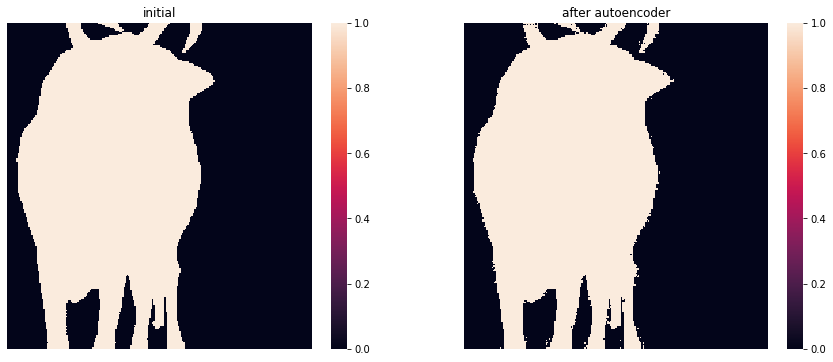

In [45]:
neptune.create_experiment(name='conv1')
conv_autoencoder, loss_history_ae = train_autoencoder(model, criterion, opt, train_loader, num_epochs, epoch_len=200)

test_model(conv_autoencoder, val_loader)
neptune.stop()

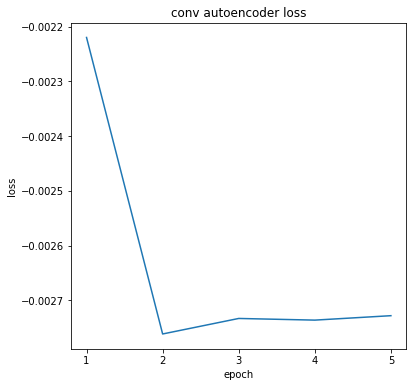

In [46]:
plt.figure(figsize=(6,6))
plt.title('conv autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [47]:
torch.save(conv_autoencoder.state_dict(), "conv_autoencoder.pth")

In [ ]:
autoencoder1 = Autoencoder().to(device)
autoencoder1.load_state_dict(torch.load('conv_autoencoder.pth'))
autoencoder1.eval()

Autoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec20): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec21): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec22): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigm): Sigmoid()
)

###Layer norm

In [48]:
class AutoencoderLN(nn.Module):
  def __init__(self):
        super(AutoencoderLN, self).__init__()
        # encoder layers
                
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.relu = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        # decoder layers
        self.dec4 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.dec3 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.dec2 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec20 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec21 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec22 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec1 = nn.ConvTranspose2d(64, 1, 3, padding=1)

        self.sigm = nn.Sigmoid()
  
   
  def forward(self, x):
        # encode
        dim0 = x.size()
        x = self.relu(self.conv1(x))
        x1, i1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x1 = F.layer_norm(x1, x1.shape)
        
        dim1 = x1.size()
        x1 = self.relu(self.conv2(x1))
        x2, i2 = F.max_pool2d(x1, kernel_size=2, stride=2, return_indices=True)
        x2 = F.layer_norm(x2, x2.shape)
       
        dim2 = x2.size()
        x2 = self.relu(self.conv3(x2))
        x3, i3 = F.max_pool2d(x2, kernel_size=2, stride=2, return_indices=True)
        x3 = F.layer_norm(x3, x3.shape)
        
        dim3 = x3.size()
        x3 = self.relu(self.conv4(x3))
        x4, i4 = F.max_pool2d(x3, kernel_size=2, stride=2, return_indices=True)
        x4 = F.layer_norm(x4, x4.shape)

        # decode
        x4 = F.max_unpool2d(x4, i4, kernel_size=2, stride=2, output_size=dim3)
        x3 = self.relu(self.dec4(x4))
        x3 = F.layer_norm(x3, x3.shape)

        x3 = F.max_unpool2d(x3, i3, kernel_size=2, stride=2, output_size=dim2)
        x2 = self.relu(self.dec3(x3))
        x2 = F.layer_norm(x2, x2.shape)

        x2 = F.max_unpool2d(x2, i2, kernel_size=2, stride=2, output_size=dim1)
        x1 = self.relu(self.dec2(x2))
        x1 = self.relu(self.dec20(x1))
        x1 = self.relu(self.dec21(x1))
        x1 = self.relu(self.dec22(x1))
        x1 = F.layer_norm(x1, x1.shape)


        x1 = F.max_unpool2d(x1, i1, kernel_size=2, stride=2, output_size=dim0)
        x = self.sigm(self.dec1(x1))
        return x

In [49]:
model = AutoencoderLN().to(device)
summary(model, (1, 256, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 224]             640
         LeakyReLU-2         [-1, 64, 256, 224]               0
            Conv2d-3         [-1, 64, 128, 112]          36,928
         LeakyReLU-4         [-1, 64, 128, 112]               0
            Conv2d-5          [-1, 128, 64, 56]          73,856
         LeakyReLU-6          [-1, 128, 64, 56]               0
            Conv2d-7          [-1, 256, 32, 28]         295,168
         LeakyReLU-8          [-1, 256, 32, 28]               0
   ConvTranspose2d-9          [-1, 128, 32, 28]         295,040
        LeakyReLU-10          [-1, 128, 32, 28]               0
  ConvTranspose2d-11           [-1, 64, 64, 56]          73,792
        LeakyReLU-12           [-1, 64, 64, 56]               0
  ConvTranspose2d-13         [-1, 64, 128, 112]          36,928
        LeakyReLU-14         [-1, 64, 1

In [51]:
model = AutoencoderLN().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = Loss(alpha=10, gamma=3)
num_epochs = 5

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-20


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/200 [00:00<?, ?it/s]

epoch [1/5], loss:-8.7395



  0%|          | 0/200 [00:00<?, ?it/s]

epoch [2/5], loss:-7.4934



  0%|          | 0/200 [00:00<?, ?it/s]

epoch [3/5], loss:-9.3449



  0%|          | 0/200 [00:00<?, ?it/s]

epoch [4/5], loss:-7.4934



100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


epoch [5/5], loss:-9.3729



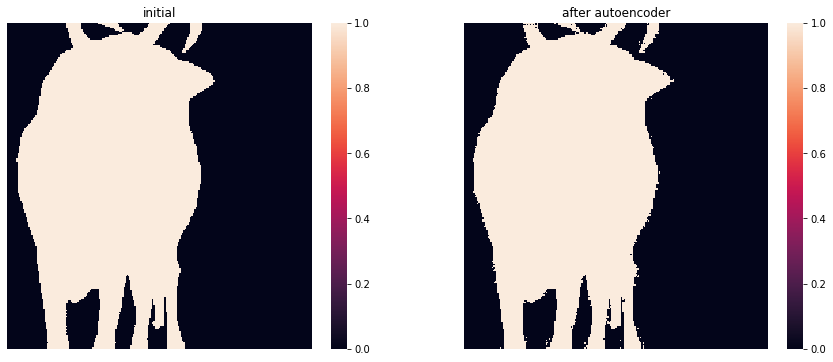

In [55]:
neptune.create_experiment(name='ln1')
ln_autoencoder, loss_history_ae = train_autoencoder(model, criterion, opt, train_loader, num_epochs, epoch_len=200)

test_model(ln_autoencoder, val_loader)
neptune.stop()

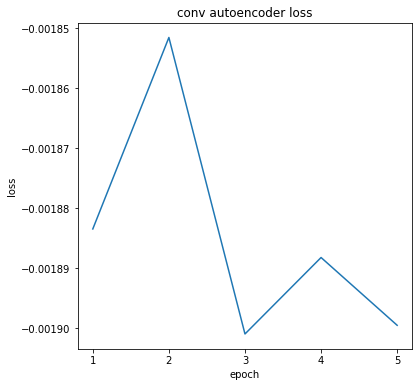

In [56]:
plt.figure(figsize=(6,6))
plt.title('conv autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [57]:
torch.save(ln_autoencoder.state_dict(), "ln_autoencoder.pth")

### Fixed size of hidden representation

In [58]:
# in progress
class FixedAutoencoder(nn.Module):
  def __init__(self):
        super(FixedAutoencoder, self).__init__()
        # encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        # expand hidden
        self.exp1 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.exp2 = nn.ConvTranspose2d(128, 64, 3, padding=1)

        # decoder layers
        self.dec4 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.dec3 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.dec2 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.dec20 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.dec21 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec22 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec1 = nn.ConvTranspose2d(64, 1, 3, padding=1)

        self.sigm = nn.Sigmoid()
        self.hid_repr = nn.AdaptiveMaxPool2d((8,8), return_indices=True)
    
  def forward(self, x):
        # encode
        dim0 = x.size()
        x = self.relu(self.conv1(x))
        x1, i1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

        dim1 = x1.size()
        x1 = self.relu(self.conv2(x1))
        x2, i2 = F.max_pool2d(x1, kernel_size=2, stride=2, return_indices=True)
 
        dim2 = x2.size()
        x2 = self.relu(self.conv3(x2))
        x3, i3 = F.max_pool2d(x2, kernel_size=2, stride=2, return_indices=True)

        dim3 = x3.size()
        x3 = self.relu(self.conv4(x3))
        x4, i4 = F.max_pool2d(x3, kernel_size=2, stride=2, return_indices=True)

        # hidden with fixed size 
        x_hid, i_hid = self.hid_repr(x4)

        # expand
        x_hid = F.max_unpool2d(x_hid, i_hid, kernel_size=2, stride=2)
        x3 = F.interpolate(x_hid, dim2[-2:])

        # decode
       # x2 = F.max_unpool2d(x3, i2, kernel_size=2, stride=2, output_size=dim1)
        x2 = self.relu(self.dec2(x3))
        x2 = self.relu(self.dec20(x2))
        x2 = self.relu(self.dec21(x2))
        x2 = self.relu(self.dec22(x2))

        x1 = F.max_unpool2d(x1, i1, kernel_size=2, stride=2, output_size=dim0)
        x = self.sigm(self.dec1(x1))
        return x

        


In [59]:
model = FixedAutoencoder().to(device)
summary(model, (1, 256, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 224]             640
              ReLU-2         [-1, 64, 256, 224]               0
            Conv2d-3         [-1, 64, 128, 112]          36,928
              ReLU-4         [-1, 64, 128, 112]               0
            Conv2d-5          [-1, 128, 64, 56]          73,856
              ReLU-6          [-1, 128, 64, 56]               0
            Conv2d-7          [-1, 256, 32, 28]         295,168
              ReLU-8          [-1, 256, 32, 28]               0
 AdaptiveMaxPool2d-9  [[-1, 256, 8, 8], [-1, 256, 8, 8]]               0
  ConvTranspose2d-10          [-1, 128, 64, 56]         295,040
             ReLU-11          [-1, 128, 64, 56]               0
  ConvTranspose2d-12           [-1, 64, 64, 56]          73,792
             ReLU-13           [-1, 64, 64, 56]               0
  ConvTranspose2d-14          

In [60]:
model = FixedAutoencoder().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = Loss(alpha=10, gamma=3)
num_epochs = 5

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-21


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/200 [00:00<00:27,  7.28it/s]

epoch [1/5], loss:-8.1140



  0%|          | 1/200 [00:00<00:30,  6.62it/s]

epoch [2/5], loss:-6.2468



  0%|          | 1/200 [00:00<00:31,  6.31it/s]

epoch [3/5], loss:-9.9934



  0%|          | 1/200 [00:00<00:35,  5.64it/s]

epoch [4/5], loss:-6.2487



100%|██████████| 200/200 [00:30<00:00,  6.51it/s]


epoch [5/5], loss:-7.4818



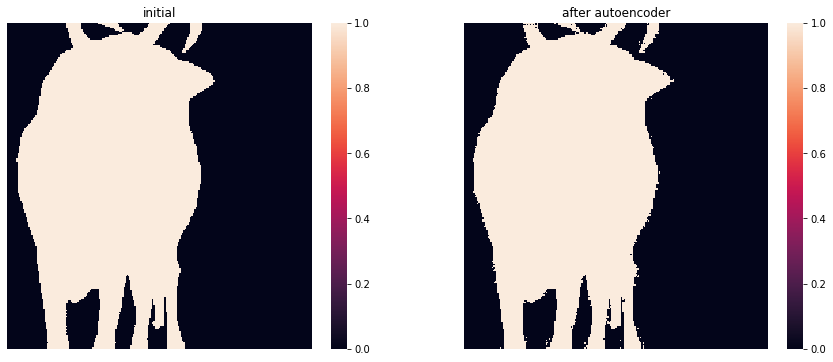

In [61]:
neptune.create_experiment(name='fix1')
fix_autoencoder, loss_history_ae = train_autoencoder(model, criterion, opt, val_loader, num_epochs, epoch_len=200)

test_model(fix_autoencoder, val_loader)
neptune.stop()

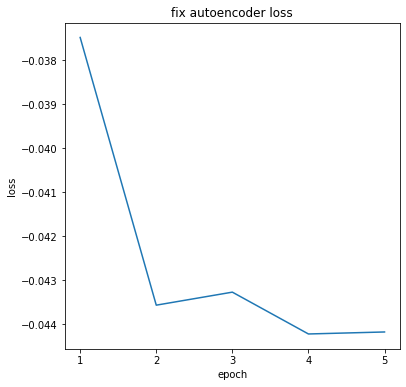

In [63]:
plt.figure(figsize=(6,6))
plt.title('fix autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [65]:
torch.save(fix_autoencoder.state_dict(), "fix_autoencoder.pth")

## Барахолка

In [ ]:
!git clone https://github.com/waleedka/coco
!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI

In [ ]:
from pycocotools.coco import COCO

annFile='annotations/instances_train2017.json'

coco=COCO(annFile)

In [ ]:
val_data = dset.CocoDetection(root = 'val2017',
                        annFile = 'annotations/instances_val2017.json',
                        transform=transform)

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


In [ ]:
#https://github.com/say4n/pytorch-segnet/blob/master/src/model.py

class Autoencoder(nn.Module):
  def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
        #    nn.LayerNorm(),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=1),
        #    nn.LayerNorm(),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, padding=1),
        #    nn.LayerNorm(),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, padding=1),
         #   nn.LayerNorm(),
            nn.ReLU()
        )
                
        # decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, padding=1),
            nn.LayerNorm(2),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 3, padding=1),
            nn.LayerNorm(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, 3, padding=1),
            nn.LayerNorm(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, 3, padding=1),
            nn.LayerNorm(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )
      
  def forward(self, x):
        # encode
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
target

[{'area': 16433.58065,
  'bbox': [120.07, 71.83, 134.49, 153.08],
  'category_id': 13,
  'id': 268988,
  'image_id': 724,
  'iscrowd': 0,
  'segmentation': [[122.51,
    174.51,
    120.07,
    110.94,
    159.68,
    71.83,
    220.33,
    81.13,
    253.1,
    128.57,
    254.56,
    186.77,
    220.33,
    224.91,
    165.55,
    224.91,
    123.98,
    178.45]]},
 {'area': 418.08004999999997,
  'bbox': [123.39, 279.44, 21.74, 30.17],
  'category_id': 8,
  'id': 1197746,
  'image_id': 724,
  'iscrowd': 0,
  'segmentation': [[124.76,
    280.61,
    128.09,
    286.88,
    142.98,
    289.04,
    145.13,
    299.42,
    142.59,
    304.12,
    141.8,
    309.61,
    134.95,
    309.61,
    132.21,
    305.1,
    130.44,
    307.26,
    126.53,
    305.69,
    123.78,
    305.69,
    123.39,
    279.44]]},
 {'area': 79.60360000000011,
  'bbox': [128.26, 267.21, 12.88, 8.15],
  'category_id': 3,
  'id': 1341991,
  'image_id': 724,
  'iscrowd': 0,
  'segmentation': [[130.39,
    267.21,

500


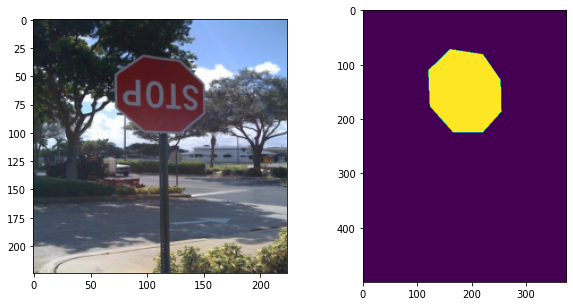

In [ ]:
img, target = val_data[3]

fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1,2,1)
plt.imshow(img.numpy().transpose((1, 2, 0)));

fig.add_subplot(1,2,2)
mask = val_data.coco.annToMask(target[0])
plt.imshow(mask);
print(len(mask))

In [ ]:
def load_data(batch_size=64):

  transform = transforms.Compose(
      [transforms.Resize([224,224]),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]
  )
  #transform = transforms.ToTensor()
  train_data = dset.CocoDetection(root = 'train2017',
                        annFile = 'annotations/instances_train2017.json',
                        transform=transform)

  print('Number of samples in train: ', len(train_data))

  val_data = dset.CocoDetection(root = 'val2017',
                        annFile = 'annotations/instances_val2017.json',
                        transform=transform)

  print('Number of samples in val: ', len(val_data))

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader

[]

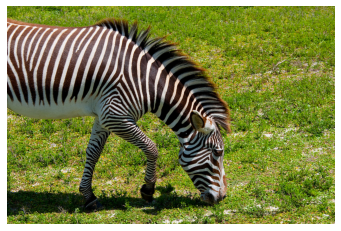

In [ ]:
plt.imshow(img.numpy().transpose((1, 2, 0)));
plt.axis('off')
catIds = [target[0]['category_id']]
annIds = train_data.coco.getAnnIds(imgIds=[target[0]['id']], catIds=catIds)
anns = train_data.coco.loadAnns(annIds)
train_data.coco.showAnns(anns)
annIds


In [ ]:
img, target = val_data[3]

In [ ]:
mask = val_data.coco.annToMask(target[0])


In [ ]:
t=transforms.ToPILImage()
mask_im = t(mask)
t = transforms.ToTensor()
t(mask_im).shape

torch.Size([1, 500, 375])

In [ ]:
type(mask_im)

PIL.Image.Image

In [ ]:
k = 3
x = torch.Tensor(np.ones((5, 3,16,16)))
x

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
        

In [ ]:
F.interpolate(x, (32, 32)).shape

torch.Size([5, 3, 32, 32])